# Normalize crops across image space

In [53]:
from functions.crop_image import random_crop
from functions.load_all_data import load_data_by_color, load_labeled_data
from skimage import io
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import numpy as np
import os
os.chdir("/raid/data/BBBC038/training/")

In [5]:
purple_png_list, purple_img_paths, purple_mask_colls = load_data_by_color(color="Purple")
def_png_list, def_img_paths, def_mask_colls = load_data_by_color(color="Default")

In [6]:
purple_crops = []
def_crops = []

# take 100 random crops of random images in the purple and default sets
for i in range(100):
    purp_idx = np.random.randint(0, len(purple_img_paths))
    def_idx = np.random.randint(0, len(def_img_paths))
    
    purp_img = io.imread(purple_img_paths[purp_idx])
    def_img = io.imread(def_img_paths[def_idx])
    
    cropped_purp = random_crop(purp_img)
    cropped_def = random_crop(def_img)
    
    purple_crops.append(cropped_purp)
    def_crops.append(cropped_def)

In [63]:
training_samples = []
training_labels = []

test_samples = []
test_labels = []

for i in range(100):
    def_idx = np.random.randint(0, len(def_img_paths) / 2)
    purp_idx = np.random.randint(0, len(purple_img_paths) / 2)
    
    def_img = io.imread(def_img_paths[def_idx])
    purp_img = io.imread(purple_img_paths[purp_idx])
    
    def_img = random_crop(def_img)
    purp_img = random_crop(purp_img)
    
    training_samples.append(def_img)
    training_samples.append(purp_img)
    
    training_labels.append(0)
    training_labels.append(1)
    
for i in range(50):
    def_idx = np.random.randint(len(def_img_paths) / 2, len(def_img_paths))
    purp_idx = np.random.randint(len(purple_img_paths) / 2, len(purple_img_paths))
    
    def_img = io.imread(def_img_paths[def_idx])
    purp_img = io.imread(purple_img_paths[purp_idx])
    
    def_img = random_crop(def_img)
    purp_img = random_crop(purp_img)
    
    
    test_samples.append(def_img)
    test_samples.append(purp_img)
    
    test_labels.append((0,0,0))
    test_labels.append((1,1,1))


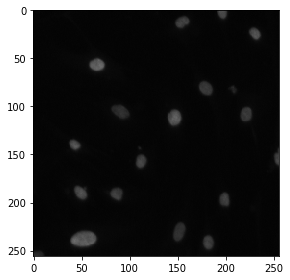

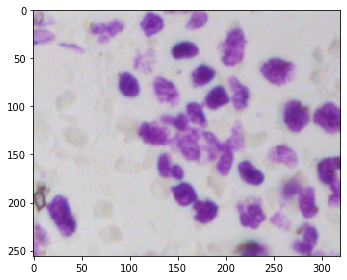

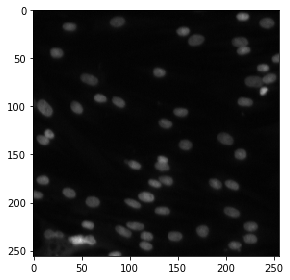

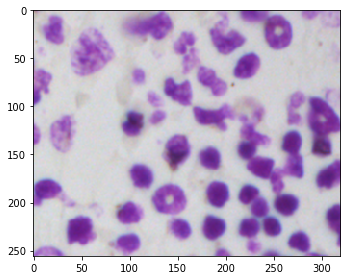

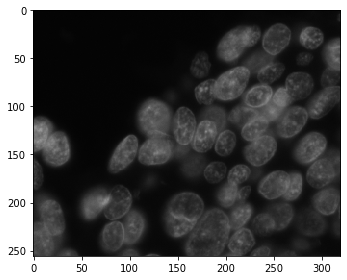

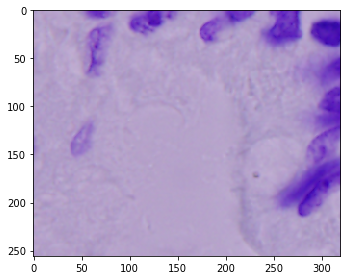

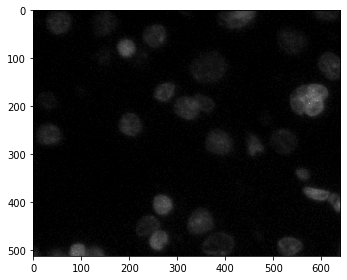

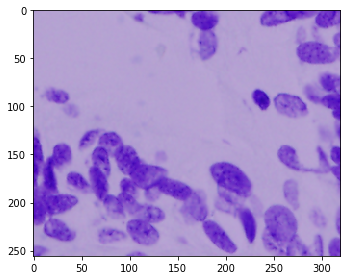

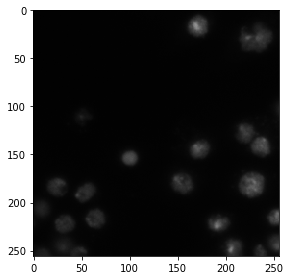

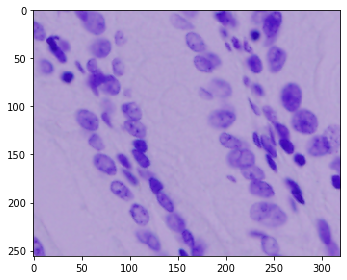

<Figure size 432x288 with 0 Axes>

In [14]:
count = 0
for i in training_samples:
    io.imshow(i)
    plt.figure()

    if count == 9: 
        break
    
    count += 1

In [64]:
training_samples = np.array(training_samples)
training_labels = np.array(training_labels)

test_samples = np.array(test_samples)
test_labels = np.array(test_labels)

In [17]:
from functions.tf_config import config_gpu

config_gpu(5, True)

8 Physical GPUs, 1 Logical GPU
Configured to run on GPU 5


In [65]:
training_samples, test_samples = training_samples / 255., test_samples / 255.

In [73]:
from tensorflow import keras
model = keras.models.Sequential([
    keras.layers.Conv2D(3, 4, input_shape=(64, 64, 3)),
    keras.layers.Dropout(0.2),
    keras.layers.Flatten()
])

In [74]:
predictions = model(training_samples).numpy()
predictions

array([[0.00171629, 0.01802438, 0.01692441, ..., 0.00157932, 0.02223681,
        0.01985718],
       [0.03015184, 0.69834125, 0.5479998 , ..., 0.02896578, 0.6947129 ,
        0.5441943 ],
       [0.01290492, 0.04017072, 0.03485443, ..., 0.00309489, 0.05149281,
        0.04953273],
       ...,
       [0.02638617, 0.7130686 , 0.5328582 , ..., 0.0151802 , 0.7145697 ,
        0.5353598 ],
       [0.0012846 , 0.01250977, 0.01523448, ..., 0.03236019, 0.21376789,
        0.20794344],
       [0.02320527, 0.7185958 , 0.5399752 , ..., 0.02474225, 0.7239907 ,
        0.54260725]], dtype=float32)

In [75]:
tf.nn.softmax(predictions).numpy()

array([[8.86352718e-05, 9.00925952e-05, 8.99935549e-05, ...,
        8.86231282e-05, 9.04729095e-05, 9.02578686e-05],
       [5.79540283e-05, 1.13051035e-04, 9.72707130e-05, ...,
        5.78853287e-05, 1.12641595e-04, 9.69012472e-05],
       [8.79078070e-05, 9.03376495e-05, 8.98586659e-05, ...,
        8.70496369e-05, 9.13662734e-05, 9.11873649e-05],
       ...,
       [5.83473156e-05, 1.15942661e-04, 9.68230743e-05, ...,
        5.76971288e-05, 1.16116840e-04, 9.70655892e-05],
       [8.80336083e-05, 8.90273659e-05, 8.92702737e-05, ...,
        9.08122602e-05, 1.08875167e-04, 1.08242872e-04],
       [5.72798599e-05, 1.14817019e-04, 9.60356119e-05, ...,
        5.73679717e-05, 1.15438117e-04, 9.62887207e-05]], dtype=float32)

In [76]:
loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=False)
# loss_fn(test_labels[:1], predictions).numpy()

In [77]:
model.compile(optimizer='adam',
             loss=loss_fn,
             metrics=['accuracy'])

In [78]:
model.fit(training_samples, training_labels, epochs=5)

Epoch 1/5
7/7 [==============================] - 0s 5ms/step - loss: 12.0119 - accuracy: 0.0000e+00
Epoch 2/5
7/7 [==============================] - 0s 3ms/step - loss: 11.7613 - accuracy: 0.0000e+00
Epoch 3/5
7/7 [==============================] - 0s 3ms/step - loss: 11.3047 - accuracy: 0.0000e+00
Epoch 4/5
7/7 [==============================] - 0s 3ms/step - loss: 10.9889 - accuracy: 0.0000e+00
Epoch 5/5
7/7 [==============================] - 0s 2ms/step - loss: 11.4677 - accuracy: 0.0000e+00
